Data from database: World Development Indicators
Last Updated: 10/26/2023

# Prediction of HDI based on Education, Income and Life index trends


## Depedencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Loading the data


In [3]:
countries=pd.read_csv("//content//drive//My Drive//Intro to AI//HDIPred//country_list.csv")
countries=countries.values

In [4]:
country_data={}
for i in countries:
  country_data[i[0]]=pd.read_csv("//content//drive//My Drive//Intro to AI//HDIPred//data//"+i[0]+".csv")

In [5]:
countries

array([['Australia'],
       ['Austria'],
       ['Canada'],
       ['China'],
       ['India']], dtype=object)

## Data Analysis

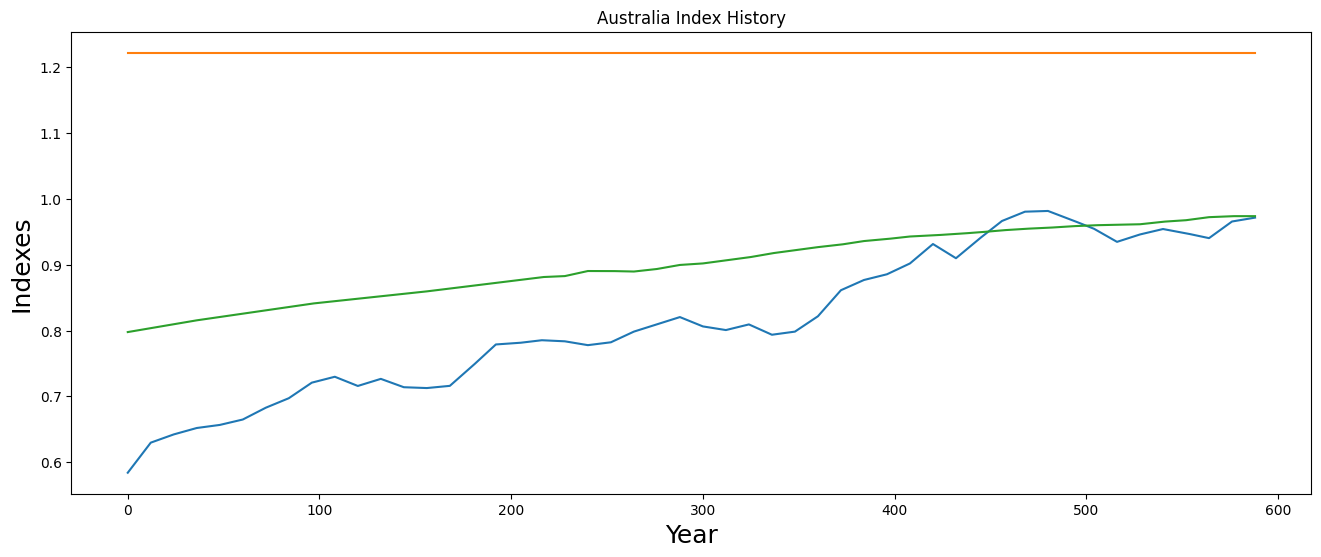

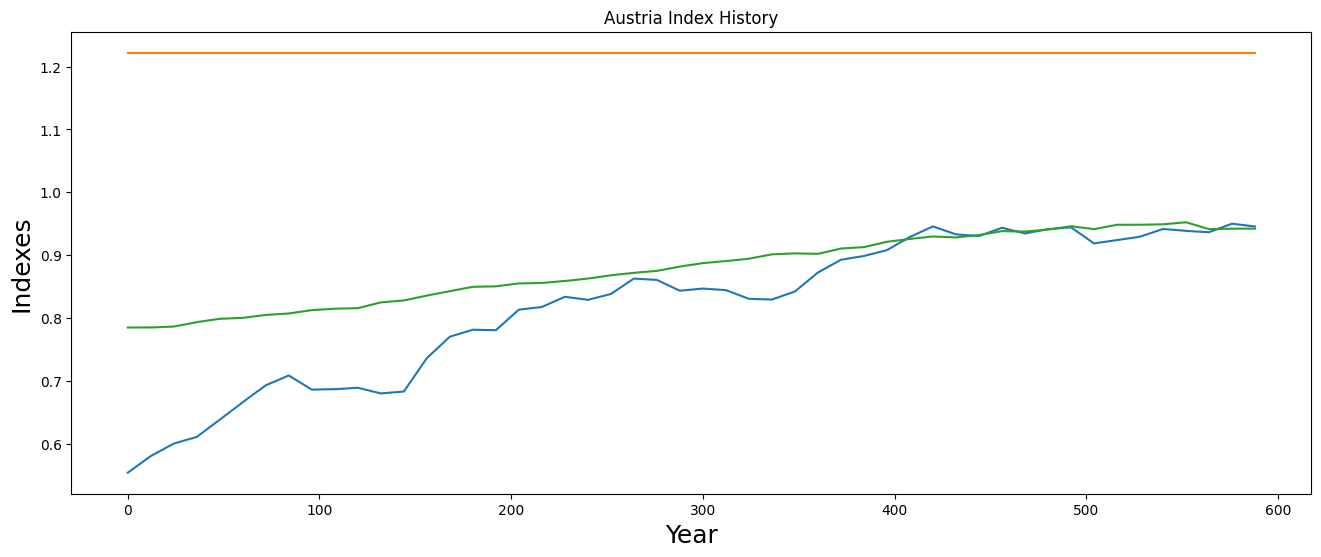

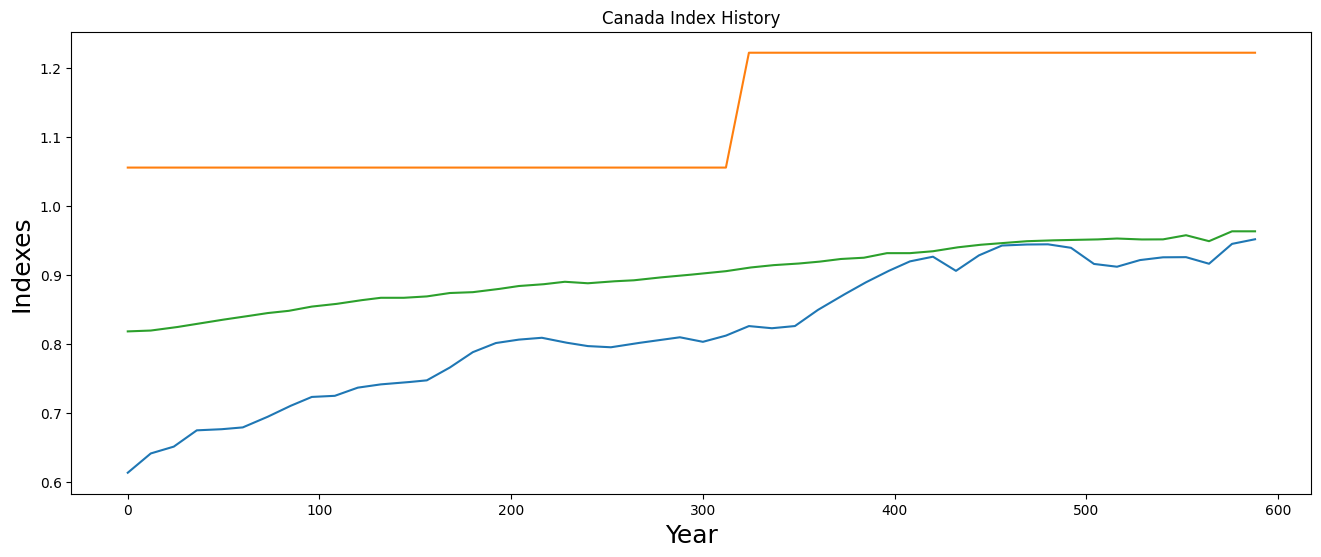

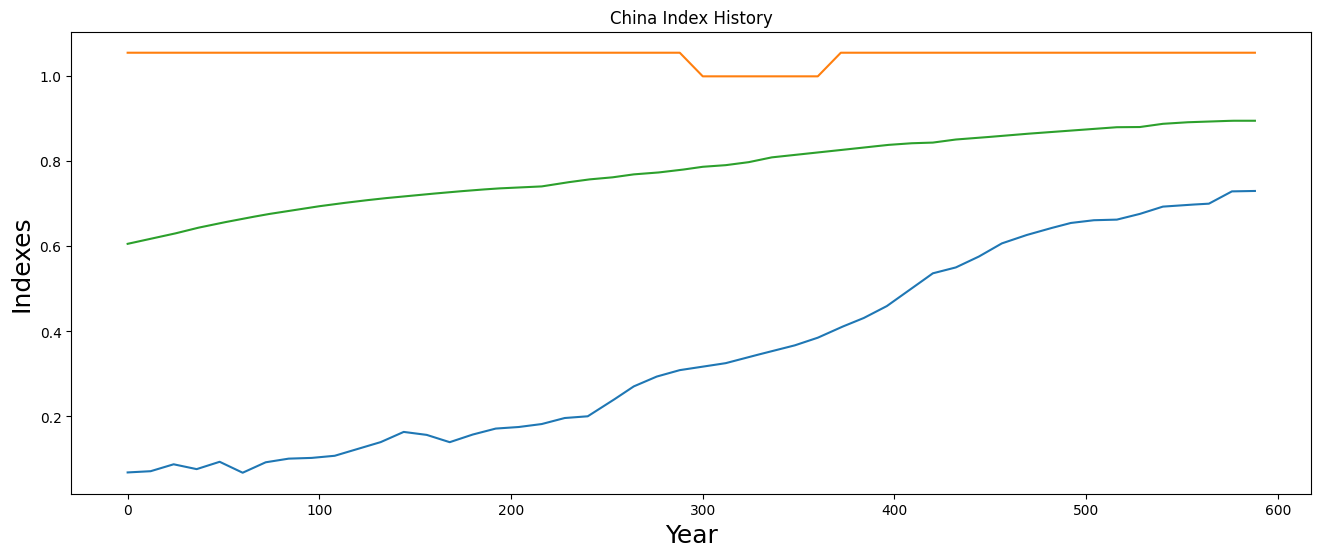

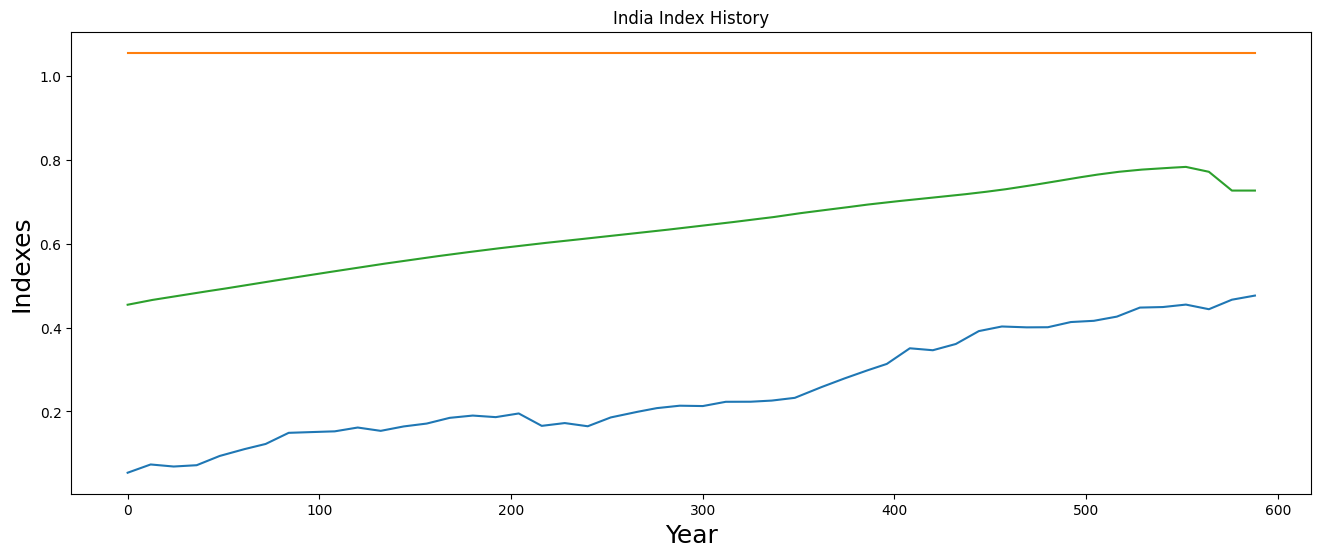

In [6]:
for i in countries:
  plt.figure(figsize=(16,6))
  plt.title(f'{i[0]} Index History')
  plt.plot(country_data[i[0]]['Income Index'])
  plt.plot(country_data[i[0]]['Education Index'])
  plt.plot(country_data[i[0]]['Life Expectancy Index'])
  plt.xlabel('Year', fontsize=18)
  plt.ylabel('Indexes', fontsize=18)
  plt.savefig(f'{i[0]}.png')

## Preprocess


### selecting the indexes for training

In [7]:
train_percent=0.8

In [8]:
#index Dictionalries
Income={}
Education={}
Life={}

for i in countries:
  i=i[0]
  Income[i]=country_data[i].filter(['Income Index']).values
  Education[i]=country_data[i].filter(['Education Index']).values
  Life[i]=country_data[i].filter(['Life Expectancy Index']).values

training_data_len=int(np.ceil(len(Income[i])*train_percent))



### Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
Scaled_Income={}
Scaled_Education={}
Scaled_Life={}
scaleri={}
scalere={}
scalerl={}

In [11]:
for i in countries:
  i=i[0]
  scaleri[i]=MinMaxScaler(feature_range=(0,1))
  Scaled_Income[i]=scaleri[i].fit_transform(Income[i])
  scalere[i]=MinMaxScaler(feature_range=(0,1))
  Scaled_Education[i]=scalere[i].fit_transform(Education[i])
  scalerl[i]=MinMaxScaler(feature_range=(0,1))
  Scaled_Life[i]=scalerl[i].fit_transform(Life[i])

In [12]:
sliding_window=100;

### Splitting the data

#### Training data

In [13]:
Education_train_x={}
Income_train_x={}
Life_train_x={}

In [14]:
Education_train_y={}
Income_train_y={}
Life_train_y={}

In [15]:
def trainSplitting(train_data,sliding_window):
  x_train=[]
  y_train=[]

  for i in range(sliding_window,len(train_data)):
    x_train.append(train_data[i-sliding_window:i,0])
    y_train.append(train_data[i,0])
    if i<=sliding_window+1:
      print()
  x_train,y_train=np.array(x_train), np.array(y_train)

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  return x_train,y_train


In [16]:
for c in countries:
  c=c[0]

  #Income data
  train_data=Scaled_Income[c][0:int(training_data_len), :]
  Income_train_x[c],Income_train_y[c]=trainSplitting(train_data,sliding_window)
  #Education data
  train_data=Scaled_Education[c][0:int(training_data_len), :]
  Education_train_x[c],Education_train_y[c]=trainSplitting(train_data,sliding_window)
  #Life Data
  train_data=Scaled_Life[c][0:int(training_data_len), :]
  Life_train_x[c],Life_train_y[c]=trainSplitting(train_data,sliding_window)

In [17]:
training_data_len

472

#### Testing Data

In [18]:
Education_test_x={}
Income_test_x={}
Life_test_x={}

In [19]:
Education_test_y={}
Income_test_y={}
Life_test_y={}

In [20]:
def testSplitting(c,test_data,sliding_window,dataset):
  x_test = []
  y_test = dataset[training_data_len:, :]
  for i in range(sliding_window,len(test_data)):
    x_test.append(test_data[i-sliding_window:i,0])

  x_test = np.array(x_test)

  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

  return x_test,y_test

In [21]:
for c in countries:
  c=c[0]

  #Income data
  test_data=Scaled_Income[c][training_data_len - sliding_window: , :]
  Income_test_x[c],Income_test_y[c]=testSplitting(c,test_data,sliding_window,Income[c])
  #Education data
  test_data=Scaled_Education[c][training_data_len - sliding_window: , :]
  Education_test_x[c],Education_test_y[c]=testSplitting(c,test_data,sliding_window,Education[c])
  #Life Data
  test_data=Scaled_Life[c][training_data_len - sliding_window: , :]
  Life_test_x[c],Life_test_y[c]=testSplitting(c,test_data,sliding_window,Life[c])

## Model Definition

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate

In [25]:
shape_use=Life_test_x['Canada'].shape[1]

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
country_models_I=[]
country_models_E=[]
country_models_L=[]
# Build the LSTM model
def model():
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (shape_use, 1)))
  model.add(LSTM(64, return_sequences=False, activation='relu'))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_squared_error'])
  return model


## Model Training

In [29]:
for i in countries:
  i=i[0]
  m=model()
  m.fit(Income_train_x[i], Income_train_y[i], batch_size=1, epochs=2)
  print(i+"Done training")
  country_models_I.append(m)

Epoch 1/2
372/372 [==============================] - 46s 115ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 2/2
372/372 [==============================] - 61s 163ms/step - loss: 0.0015 - mean_squared_error: 0.0015
AustraliaDone training


Epoch 1/2
372/372 [==============================] - 46s 117ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 2/2
372/372 [==============================] - 41s 111ms/step - loss: 0.0011 - mean_squared_error: 0.0011
AustriaDone training


Epoch 1/2
372/372 [==============================] - 46s 113ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 2/2
372/372 [==============================] - 44s 117ms/step - loss: 9.7396e-04 - mean_squared_error: 9.7396e-04
CanadaDone training


Epoch 1/2
372/372 [==============================] - 45s 114ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 2/2
372/372 [==============================] - 42s 112ms/step - loss: 6.0706e-04 - mean_squared_error: 6.0706e-04
ChinaDone training


Epoch 1/2
372/372 [==============================] - 45s 112ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 2/2
372/372 [==============================] - 42s 113ms/step - loss: 7.5785e-04 - mean_squared_error: 7.5785e-04
IndiaDone training


In [30]:
for i in countries:
  i=i[0]
  m=model()
  m.fit(Education_train_x[i], Education_train_y[i], batch_size=1, epochs=2)
  country_models_E.append(m)

Epoch 1/2
372/372 [==============================] - 44s 111ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00
Epoch 2/2
372/372 [==============================] - 41s 109ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00


Epoch 1/2
372/372 [==============================] - 45s 114ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00
Epoch 2/2
372/372 [==============================] - 40s 109ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00


Epoch 1/2
372/372 [==============================] - 46s 114ms/step - loss: 19834.7598 - mean_squared_error: 19834.7598
Epoch 2/2
372/372 [==============================] - 41s 110ms/step - loss: 0.0134 - mean_squared_error: 0.0134


Epoch 1/2
372/372 [==============================] - 44s 108ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 2/2
372/372 [==============================] - 42s 114ms/step - loss: 0.0051 - mean_squared_error: 0.0051


Epoch 1/2
372/372 [==============================] - 44s 113ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00
Epoch 2/2
372/372 [==============================] - 42s 112ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00


In [31]:
for i in countries:
  i=i[0]
  m=model()
  m.fit(Life_train_x[i], Life_train_x[i], batch_size=1, epochs=2)
  country_models_L.append(m)

Epoch 1/2
372/372 [==============================] - 45s 115ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 2/2
372/372 [==============================] - 41s 109ms/step - loss: 0.0037 - mean_squared_error: 0.0037


Epoch 1/2
372/372 [==============================] - 43s 109ms/step - loss: 0.0167 - mean_squared_error: 0.0167
Epoch 2/2
372/372 [==============================] - 43s 116ms/step - loss: 0.0042 - mean_squared_error: 0.0042


Epoch 1/2
372/372 [==============================] - 47s 117ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 2/2
372/372 [==============================] - 40s 109ms/step - loss: 0.0037 - mean_squared_error: 0.0037


Epoch 1/2
372/372 [==============================] - 45s 112ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 2/2
372/372 [==============================] - 45s 120ms/step - loss: 0.0040 - mean_squared_error: 0.0040


Epoch 1/2
372/372 [==============================] - 48s 121ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 2/2
372/372 [==============================] - 43s 116ms/step - loss: 0.0029 - mean_squared_error: 0.0029


In [32]:
m=model()
m.fit(Income_train_x['Canada'], Income_train_y['Canada'], batch_size=1, epochs=2)

Epoch 1/2
372/372 [==============================] - 46s 113ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 2/2
372/372 [==============================] - 44s 119ms/step - loss: 6.1227e-04 - mean_squared_error: 6.1227e-04


## Prediction and analysis of performance

In [33]:
# Get the models predicted price values
def prediction(model_list,test_set_x,test_set_y,scaler_list):
  predictions_set={}
  rmse=[]
  count=0
  for i in countries:
    i=i[0]
    predictions =model_list[count].predict(test_set_x[i])
    predictions = scaler_list[i].inverse_transform(predictions)
    predictions_set[i]=predictions
    rmse.append(np.sqrt(np.mean(((predictions - test_set_y[i]) ** 2))))
    count +=1
    data = {key: value.flatten() for key, value in predictions_set.items()}
  return data,rmse

In [34]:
pred_I=prediction(country_models_I,Income_test_x,Income_test_y,scaleri)
pred_E=prediction(country_models_E,Education_test_x,Education_test_y,scalere)
pred_L=prediction(country_models_L,Life_test_x,Life_test_y,scalerl)

4/4 [==============================] - 1s 30ms/step


In [38]:
countries_predictions_Income=pred_I[0]
countries_predictions_Education=pred_E[0]
countries_predictions_Life=pred_L[0]

Income_pred=pd.DataFrame(countries_predictions_Income,columns=countries_predictions_Income.keys())
Education_pred=pd.DataFrame(countries_predictions_Education,columns=countries_predictions_Education.keys())
Life_pred=pd.DataFrame(countries_predictions_Life,columns=countries_predictions_Life.keys())

Income_pred.to_csv('Income_pred_hyperparamless.csv')
Education_pred.to_csv('Education_pred_hyperparamless.csv')
Life_pred.to_csv('Life_pred_hyperparamless.csv')


In [39]:

import pickle
best_models=[country_models_I,country_models_E,country_models_L]
# Assuming 'best_model' is the model you want to save
# Save the best model to a file named 'best_model.pkl'
with open('best_model_hyperless.pkl', 'wb') as file:
    pickle.dump(best_models, file)


<ipython-input-40-b8e1715094ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pred_I[0]['Canada']  # Assign the predictions directly if they align with the 'valid' DataFrame's index


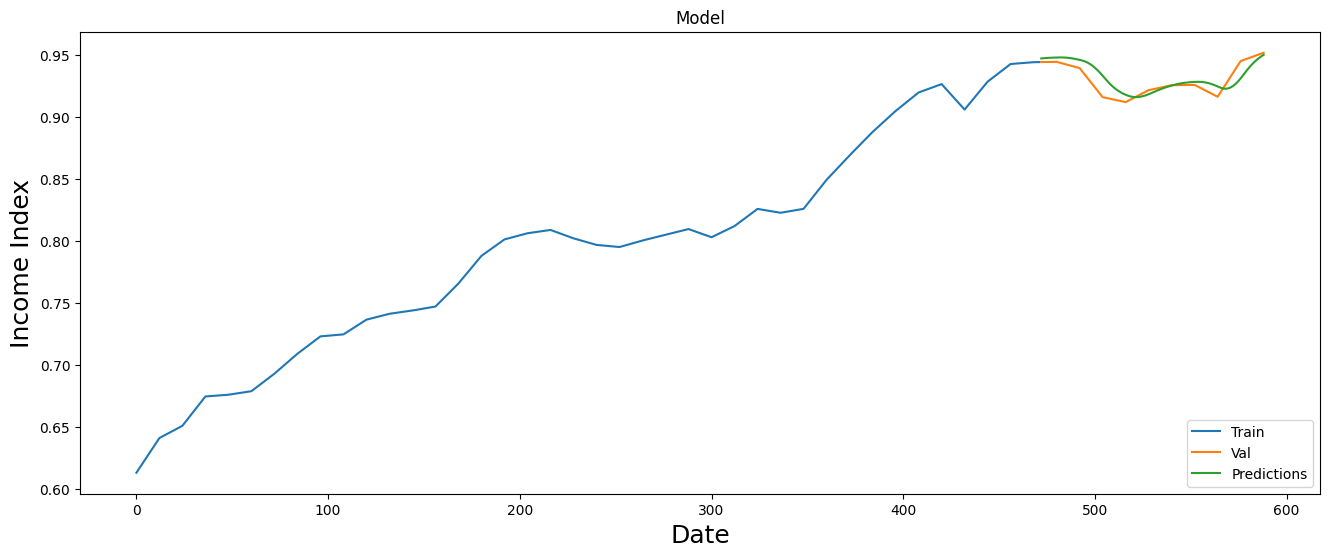

In [40]:
# Plot the data
train = country_data['Canada'][:training_data_len]
valid = country_data['Canada'][training_data_len:]
# Assuming pred_E[0] contains predictions with indices corresponding to 'valid' DataFrame
valid['Predictions'] = pred_I[0]['Canada']  # Assign the predictions directly if they align with the 'valid' DataFrame's index

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Income Index', fontsize=18)
plt.plot(train['Income Index'])
plt.plot(valid[['Income Index', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Making Future Predictions

In [54]:
# Initialize dictionaries to store future predictions for each feature
future_predictions_Income = {country[0]: [] for country in countries}
future_predictions_Education = {country[0]: [] for country in countries}
future_predictions_Life = {country[0]: [] for country in countries}

for country in countries:
    country_name = country[0]
    current_sequence_income = Income_test_x[country_name][-2]
    current_sequence_education = Education_test_x[country_name][-2]
    current_sequence_life = Life_test_x[country_name][-2]

    for i in range(future_steps):
        # Reshape the current sequences to match the LSTM input shape
        reshaped_sequence_income = current_sequence_income.reshape(1, current_sequence_income.shape[0], 1)
        reshaped_sequence_education = current_sequence_education.reshape(1, current_sequence_education.shape[0], 1)
        reshaped_sequence_life = current_sequence_life.reshape(1, current_sequence_life.shape[0], 1)

        # Predict the next time step for each feature
        next_step_prediction_income = country_models_I[0].predict(reshaped_sequence_income)
        next_step_prediction_education = country_models_E[0].predict(reshaped_sequence_education)
        next_step_prediction_life = country_models_L[0].predict(reshaped_sequence_life)

        # Append the predicted values to the sequences
        current_sequence_income = np.append(current_sequence_income[1:], next_step_prediction_income, axis=0)
        current_sequence_education = np.append(current_sequence_education[1:], next_step_prediction_education, axis=0)
        current_sequence_life = np.append(current_sequence_life[1:], next_step_prediction_life, axis=0)

        # Store the predictions for each country
        future_predictions_Income[country_name].append(next_step_prediction_income[0][0])
        future_predictions_Education[country_name].append(next_step_prediction_education[0][0])
        future_predictions_Life[country_name].append(next_step_prediction_life[0][0])

# Flatten the values for each country in the dictionaries
for country in countries:
    country_name = country[0]
    future_predictions_Income[country_name] = np.array(future_predictions_Income[country_name]).flatten()
    future_predictions_Education[country_name] = np.array(future_predictions_Education[country_name]).flatten()
    future_predictions_Life[country_name] = np.array(future_predictions_Life[country_name]).flatten()

# Saving future predictions as CSV for each feature
def save_to_csv(predictions, file_name):
    df = pd.DataFrame(predictions)
    df.to_csv(file_name, index=False)

save_to_csv(future_predictions_Income, 'Income_pred_hyperparamless.csv')
save_to_csv(future_predictions_Education, 'Education_pred_hyperparamless.csv')
save_to_csv(future_predictions_Life, 'Life_pred_hyperparamless.csv')


1/1 [==============================] - 0s 30ms/step


## HyperParameter Tuning

In [57]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [61]:
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch

# Define the function to build your model
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units', min_value=128, max_value=512, step=32),
                                return_sequences=True,
                                input_shape=(shape_use, 1)))
    model.add(keras.layers.LSTM(units=hp.Int('units', min_value=64, max_value=512, step=32),
                                return_sequences=True,
                                input_shape=(shape_use, 1)))

    model.add(Dense(25, activation='relu'))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

# Set the hyperparameters for the search space
def calltuner():
  tuner = RandomSearch(
    build_model,
    objective='mean_squared_error',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='hdi_prediction'
  )
  return tuner




In [63]:
# Start the search for the best hyperparameters
for i in countries:
  bestI=[]
  bestE=[]
  bestL=[]
  i=i[0]
  tuner=calltuner()
  tuner.search(Income_train_x[i], Income_train_y[i],
             epochs=5,
             validation_split=0.2)
  bestI.append(tuner.get_best_models(num_models=1))
  tuner=calltuner()
  tuner.search(Education_train_x[i], Education_train_y[i],
             epochs=5,
             validation_split=0.2)
  bestE.append(tuner.get_best_models(num_models=1))
  tuner=calltuner()
  tuner.search(Life_train_x[i], Life_train_y[i],
             epochs=5,
             validation_split=0.2)
  bestL.append(tuner.get_best_models(num_models=1))

Reloading Tuner from my_dir/hdi_prediction/tuner0.json


Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json


Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json


Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json


Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json


Reloading Tuner from my_dir/hdi_prediction/tuner0.json
Reloading Tuner from my_dir/hdi_prediction/tuner0.json


## Performance Evaluation


In [ ]:
pred_I=prediction(bestI,Income_test_x,Income_test_y,scaleri)
pred_E=prediction(bestE,Education_test_x,Education_test_y,scalere)
pred_L=prediction(bestL,Life_test_x,Life_test_y,scalerl)

In [ ]:
countries_predictions_Income=pred_I[0]
countries_predictions_Education=pred_E[0]
countries_predictions_Life=pred_L[0]

Income_pred=pd.DataFrame(countries_predictions_Income,columns=countries_predictions_Income.keys())
Education_pred=pd.DataFrame(countries_predictions_Education,columns=countries_predictions_Education.keys())
Life_pred=pd.DataFrame(countries_predictions_Life,columns=countries_predictions_Life.keys())


Income_pred.to_csv('Income_pred.csv')
Education_pred.to_csv('Education_pred.csv')
Life_pred.to_csv('Life_pred.csv')


In [ ]:

import pickle
best_models=[bestI,bestE,bestL]

with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_models, file)
